# Data Preprocessing

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 984.0/984.0 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import yaml
from sklearn.model_selection import train_test_split
from google.colab import drive
import random
from PIL import Image
from ultralytics import YOLO
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python matplotlib

In [ ]:
base_dir = Path('/content/drive/MyDrive/BrainTumorYolov8')  # Adjust to your dataset path

In [ ]:
def check_dataset():
    """
    Verify the dataset structure and check for image-label pairs.
    Handles complex image filenames (e.g., 24_jpg.rf.08504de242b2d3dc8f4e414fe35f40fc.jpg).
    """
    splits = ['train', 'valid', 'test']
    for split in splits:
        img_dir = base_dir / split / 'images'
        label_dir = base_dir / split / 'labels'

        # Check if directories exist
        if not img_dir.exists():
            print(f"Error: Image directory {img_dir} does not exist")
            continue
        if not label_dir.exists():
            print(f"Error: Label directory {label_dir} does not exist")
            continue

        # List directory contents for debugging
        print(f"\nContents of {img_dir}:")
        dir_contents = os.listdir(img_dir)
        if dir_contents:
            print(f"Found {len(dir_contents)} files: {dir_contents[:5]}...")  # Show first 5 files
        else:
            print("Directory is empty")

        # Find image files with .jpg extension (case-insensitive)
        img_files = list(img_dir.glob('.jpg')) + list(img_dir.glob('.JPG'))
        # Additional check using os.listdir for robustness
        img_files_alt = [img_dir / f for f in dir_contents if f.lower().endswith(('.jpg', '.jpeg'))]

        label_files = list(label_dir.glob('*.txt'))
        print(f"{split} set: {len(img_files)} images (glob), {len(img_files_alt)} images (listdir), {len(label_files)} labels")

        if not img_files and not img_files_alt:
            print(f"Warning: No images found in {img_dir}. Check file extensions or directory access.")

        # Use img_files_alt if glob fails
        img_files = img_files if img_files else img_files_alt

        img_names = {f.stem for f in img_files}
        label_names = {f.stem for f in label_files}
        missing_labels = img_names - label_names
        missing_images = label_names - img_names
        if missing_labels:
            print(f"Warning: {len(missing_labels)} images missing labels in {split}: {list(missing_labels)[:5]}...")
        if missing_images:
            print(f"Warning: {len(missing_images)} labels missing images in {split}: {list(missing_images)[:5]}...")

check_dataset()


Contents of /content/drive/MyDrive/BrainTumorYolov8/train/images:
Found 2144 files: ['2475_jpg.rf.5e270d1a05affa156a11509e3718707f.jpg', '2419_jpg.rf.c7b4b829e23018617a9e9196b4cf7a12.jpg', '245_jpg.rf.02cc5a798919ae3fb189edf823c90121.jpg', '2503_jpg.rf.7648a395544de2f9082ae210b2959efd.jpg', '2462_jpg.rf.2923572a39e842583dafd29bfd5c3b4c.jpg']...
train set: 0 images (glob), 2144 images (listdir), 2144 labels

Contents of /content/drive/MyDrive/BrainTumorYolov8/valid/images:
Found 612 files: ['1014_jpg.rf.a4302ad28893c013da7b17a8918e0e12.jpg', '1020_jpg.rf.441c10ece61710fd03a5a0d354a650fc.jpg', '1044_jpg.rf.d30ddcc4cb73ddae9220c6b5c6871aed.jpg', '1023_jpg.rf.165e47edf5017a70999304084107d18b.jpg', '100_jpg.rf.e40ec6f3d061b0681fc465ad37e4371d.jpg']...
valid set: 0 images (glob), 612 images (listdir), 612 labels

Contents of /content/drive/MyDrive/BrainTumorYolov8/test/images:
Found 308 files: ['1037_jpg.rf.7c415f051556bbba83bc00f70fe54818.jpg', '102_jpg.rf.e58e0fc30dfea3a7a410d7b901223f16.

In [ ]:
def visualize_bounding_boxes(img_path, label_path):
    """
    Visualize an image with its bounding box annotations.
    """
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Could not read image {img_path}")
        return
    # Convert to RGB for visualization (to draw colored boxes)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    height, width = img.shape
    try:
        with open(label_path, 'r') as f:
            labels = f.readlines()
    except Exception as e:
        print(f"Error: Could not read label file {label_path}: {e}")
        return
    for label in labels:
        parts = label.strip().split()
        if len(parts) < 5:
            print(f"Warning: Invalid label format in {label_path}: {label}")
            continue
        try:
            class_id = int(parts[0])
            x_center, y_center, box_width, box_height = map(float, parts[1:5])
        except ValueError:
            print(f"Warning: Invalid numeric values in {label_path}: {label}")
            continue
        x_center = int(x_center * width)
        y_center = int(y_center * height)
        box_width = int(box_width * width)
        box_height = int(box_height * height)
        x1 = int(x_center - box_width / 2)
        y1 = int(y_center - box_height / 2)
        x2 = int(x_center + box_width / 2)
        y2 = int(y_center + box_height / 2)
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_rgb, f"Class {class_id}", (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Image: {img_path.name}")
    plt.show()

Visualizing: /content/drive/MyDrive/BrainTumorYolov8/train/images/2747_jpg.rf.b918741155389157ebf5bdc43e66b87c.jpg


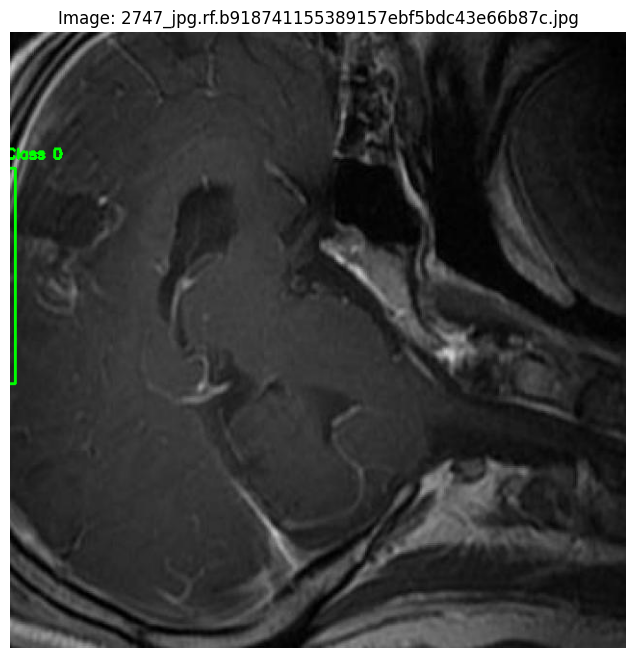

Visualizing: /content/drive/MyDrive/BrainTumorYolov8/train/images/2639_jpg.rf.ed82f826e75d482fd782b1a95a996c34.jpg


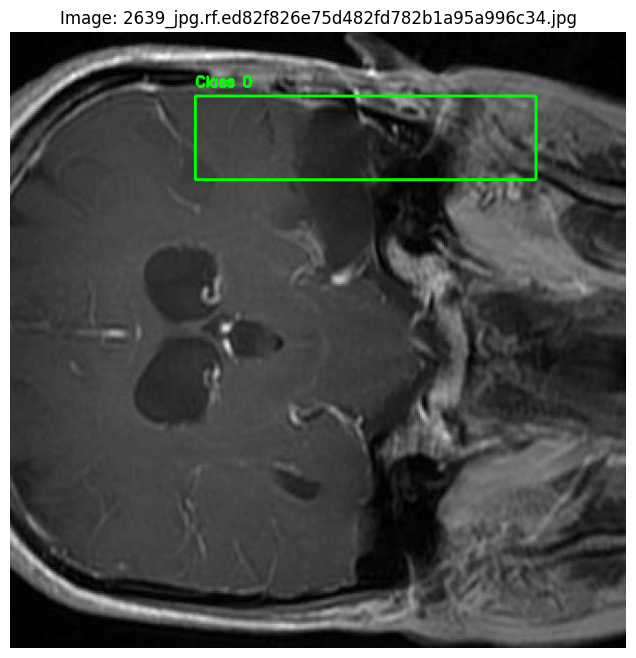

Visualizing: /content/drive/MyDrive/BrainTumorYolov8/train/images/2091_jpg.rf.be4246a2c2f102cbb437520fd82b7d94.jpg


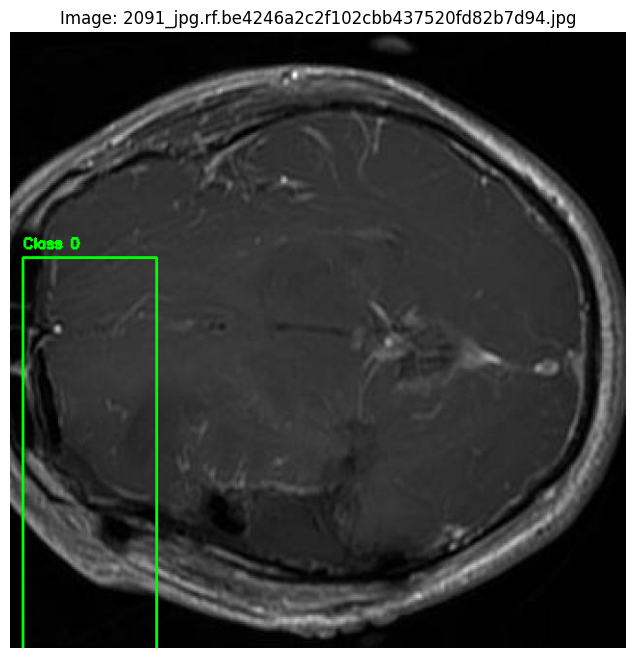

In [ ]:
def visualize_examples(split, num_examples=3):
    """
    Visualize multiple examples from a specific split to confirm data integrity.
    Handles complex image filenames.
    """
    labels_dir = base_dir / split / 'labels'
    if not labels_dir.exists():
        print(f"Error: Labels directory {labels_dir} does not exist")
        return
    label_files = list(labels_dir.glob('*.txt'))
    if not label_files:
        print(f"No labels found in {labels_dir}")
        return
    samples = random.sample(label_files, min(num_examples, len(label_files)))
    for label_path in samples:
        # Extract base filename from label (e.g., '24_jpg.rf.08504de242b2d3dc8f4e414fe35f40fc')
        label_base = label_path.stem
        # Try finding the corresponding image
        img_dir = base_dir / split / 'images'
        img_extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG']
        img_path = None
        for ext in img_extensions:
            candidate = img_dir / (label_base + ext)
            if candidate.exists():
                img_path = candidate
                break
        if img_path and img_path.exists():
            print(f"Visualizing: {img_path}")
            visualize_bounding_boxes(img_path, label_path)
        else:
            print(f"Image not found for {label_path} with any common extension")

# Visualize samples from the train set
visualize_examples('train', num_examples=3)

In [ ]:
# Step 7: Verify data.yaml
yaml_path = base_dir / 'data.yaml'
if not yaml_path.exists():
    print("Error: data.yaml not found. Creating a new one.")
    yaml_content = f"""
path: {str(base_dir)}
train: train/images
val: valid/images
test: test/images
names:
  0: tumor
"""
    with open(yaml_path, 'w') as f:
        f.write(yaml_content)
    print(f"Created data.yaml at {yaml_path}")
else:
    print(f"Found data.yaml at {yaml_path}")

Found data.yaml at /content/drive/MyDrive/BrainTumorYolov8/data.yaml


# Train

In [ ]:
from IPython import display
display.clear_output()

In [ ]:
# Load a pretrained YOLOv8n model from Ultralytics
T_Model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 112MB/s]


In [ ]:
# Train the model on our custom dataset
results = T_Model.train( data= yaml_path,epochs=50,patience=20, batch= -1, optimizer='auto', project='/content/drive/MyDrive/BrainTumorYolov8/yolov8_runs',
    name='brain_tumor_yolov8')

Ultralytics 8.3.116 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/BrainTumorYolov8/data.yaml, epochs=50, time=None, patience=20, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/BrainTumorYolov8/yolov8_runs, name=brain_tumor_yolov8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fals

100%|██████████| 755k/755k [00:00<00:00, 19.7MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1     37248  ultralytics.nn.modules.block.C2f             [192, 64, 1]                  
 16                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  1    123648  ultralytics.nn.modules.block.C2f             [192, 128, 1]                 
 19                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384,

100%|██████████| 5.35M/5.35M [00:00<00:00, 95.5MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 3.5±6.5 ms, read: 0.1±0.0 MB/s, size: 31.9 KB)


train: Scanning /content/drive/MyDrive/BrainTumorYolov8/train/labels... 2144 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2144/2144 [18:03<00:00,  1.98it/s]


train: New cache created: /content/drive/MyDrive/BrainTumorYolov8/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 2143, len(boxes) = 2144. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.74G total, 0.10G reserved, 0.08G allocated, 14.56G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3011433       8.196         0.377          42.8         381.1        (1, 3, 640, 640)                    list
     3011433       16

train: Scanning /content/drive/MyDrive/BrainTumorYolov8/train/labels.cache... 2144 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2144/2144 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 2143, len(boxes) = 2144. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 1.5±2.3 ms, read: 0.1±0.0 MB/s, size: 30.9 KB)


val: Scanning /content/drive/MyDrive/BrainTumorYolov8/valid/labels... 612 images, 0 backgrounds, 0 corrupt: 100%|██████████| 612/612 [10:09<00:00,  1.00it/s]

val: New cache created: /content/drive/MyDrive/BrainTumorYolov8/valid/labels.cache


Plotting labels to /content/drive/MyDrive/BrainTumorYolov8/yolov8_runs/brain_tumor_yolov8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004765625), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/BrainTumorYolov8/yolov8_runs/brain_tumor_yolov8
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.36G       1.34      3.849      1.409         17        640: 100%|██████████| 36/36 [00:42<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:08<00:00,  1.40s/it]


                   all        612        612     0.0046       0.73      0.312      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.35G      1.261      2.588      1.312         16        640: 100%|██████████| 36/36 [00:37<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


                   all        612        612       0.24       0.14      0.114     0.0688

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.35G      1.327      2.227       1.38         13        640: 100%|██████████| 36/36 [00:39<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


                   all        612        612      0.673      0.146      0.151     0.0935

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.35G      1.304      1.926      1.368         12        640: 100%|██████████| 36/36 [00:39<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]

                   all        612        612      0.341      0.293      0.243      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.35G      1.286      1.681      1.344         15        640: 100%|██████████| 36/36 [00:40<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.08s/it]

                   all        612        612       0.34      0.343       0.26      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.35G      1.212      1.498        1.3         12        640: 100%|██████████| 36/36 [00:39<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


                   all        612        612      0.422      0.576      0.443      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.35G      1.189      1.421       1.29         14        640: 100%|██████████| 36/36 [00:41<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.22s/it]

                   all        612        612      0.351      0.336      0.256      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.35G      1.145      1.251      1.245          9        640: 100%|██████████| 36/36 [00:39<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


                   all        612        612      0.732      0.647      0.731      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.35G      1.158       1.28       1.27         16        640: 100%|██████████| 36/36 [00:39<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


                   all        612        612      0.649      0.441      0.493      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.35G      1.127      1.215       1.25         15        640: 100%|██████████| 36/36 [00:39<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


                   all        612        612      0.547       0.61      0.623      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.34G       1.13       1.17      1.248         16        640: 100%|██████████| 36/36 [00:38<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:09<00:00,  1.60s/it]

                   all        612        612      0.742      0.724      0.761      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.35G      1.108      1.138      1.233         18        640: 100%|██████████| 36/36 [00:38<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]

                   all        612        612      0.674        0.7      0.733      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.35G      1.109      1.117      1.236         15        640: 100%|██████████| 36/36 [00:38<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:08<00:00,  1.37s/it]

                   all        612        612      0.659      0.642      0.686       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.35G      1.059      1.056      1.201          8        640: 100%|██████████| 36/36 [00:38<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]

                   all        612        612      0.757       0.64      0.731      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.35G      1.067      1.021      1.198         16        640: 100%|██████████| 36/36 [00:38<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.06s/it]

                   all        612        612      0.731      0.545      0.624      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.34G      1.073       1.04      1.212         15        640: 100%|██████████| 36/36 [00:38<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]

                   all        612        612      0.715      0.547      0.622      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.35G      1.019     0.9764       1.18         13        640: 100%|██████████| 36/36 [00:38<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.26s/it]

                   all        612        612      0.842      0.754      0.825      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.35G      1.035     0.9722      1.186         13        640: 100%|██████████| 36/36 [00:39<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


                   all        612        612      0.698      0.603      0.713      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.35G      1.017      0.965      1.189          9        640: 100%|██████████| 36/36 [00:39<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]

                   all        612        612        0.8      0.701      0.773      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.34G      1.007     0.9447      1.177         21        640: 100%|██████████| 36/36 [00:39<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.15s/it]

                   all        612        612      0.772      0.754      0.816      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.34G     0.9942     0.8821      1.166         14        640: 100%|██████████| 36/36 [00:39<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]

                   all        612        612        0.8      0.779       0.83      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.34G       1.01     0.9082      1.184         15        640: 100%|██████████| 36/36 [00:40<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.15s/it]

                   all        612        612      0.848      0.791      0.851      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.34G     0.9586     0.8611      1.141         19        640: 100%|██████████| 36/36 [00:39<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:08<00:00,  1.40s/it]

                   all        612        612      0.778      0.779      0.831      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.34G     0.9727      0.857      1.146         14        640: 100%|██████████| 36/36 [00:38<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]

                   all        612        612      0.792      0.787      0.835      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.35G     0.9471     0.8292      1.137         11        640: 100%|██████████| 36/36 [00:38<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


                   all        612        612      0.803      0.789      0.816      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.34G     0.9554     0.8169      1.142         20        640: 100%|██████████| 36/36 [00:40<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.33s/it]

                   all        612        612      0.797      0.841      0.856      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.34G     0.9582     0.8117      1.148         18        640: 100%|██████████| 36/36 [00:39<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


                   all        612        612      0.853       0.83      0.884      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.34G     0.9277     0.8044      1.137         12        640: 100%|██████████| 36/36 [00:38<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:08<00:00,  1.36s/it]

                   all        612        612      0.637      0.632      0.719      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.35G     0.9433     0.7971      1.133         10        640: 100%|██████████| 36/36 [00:38<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]

                   all        612        612      0.859      0.805      0.877      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.35G     0.9326     0.7643      1.118          9        640: 100%|██████████| 36/36 [00:39<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


                   all        612        612      0.831      0.787      0.842      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.34G     0.8943     0.7536      1.108         14        640: 100%|██████████| 36/36 [00:39<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]

                   all        612        612      0.864      0.796      0.864      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.35G     0.8882     0.7233      1.101         10        640: 100%|██████████| 36/36 [00:38<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]

                   all        612        612      0.838      0.828      0.875      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.34G      0.893     0.7177      1.101         19        640: 100%|██████████| 36/36 [00:39<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:08<00:00,  1.40s/it]

                   all        612        612      0.859      0.831      0.884      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.34G     0.8701     0.6751      1.088         14        640: 100%|██████████| 36/36 [00:41<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.08s/it]

                   all        612        612      0.885      0.825      0.904       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.34G     0.8631     0.6689      1.088         18        640: 100%|██████████| 36/36 [00:39<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]

                   all        612        612      0.899       0.85      0.909       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.34G     0.8773     0.6777      1.092         19        640: 100%|██████████| 36/36 [00:38<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.26s/it]

                   all        612        612      0.894      0.819      0.899      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.34G     0.8551     0.6776      1.078         14        640: 100%|██████████| 36/36 [00:38<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

                   all        612        612      0.896      0.809      0.899      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.34G     0.8359     0.6367      1.078         15        640: 100%|██████████| 36/36 [00:38<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]

                   all        612        612      0.882      0.845      0.902      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.35G     0.8394     0.6505      1.077         14        640: 100%|██████████| 36/36 [00:37<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.33s/it]

                   all        612        612      0.896      0.843      0.903      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.34G     0.8335     0.6462      1.069         13        640: 100%|██████████| 36/36 [00:38<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

                   all        612        612      0.865      0.845      0.892      0.675


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.34G     0.7478     0.5532      1.021          9        640: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]

                   all        612        612      0.894      0.831      0.895      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.35G     0.7127     0.4782     0.9954          9        640: 100%|██████████| 36/36 [00:37<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.06s/it]

                   all        612        612      0.895      0.843      0.897      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.34G     0.7125     0.4648      0.982          9        640: 100%|██████████| 36/36 [00:37<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]

                   all        612        612      0.908      0.846      0.913      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.34G      0.686      0.453     0.9712          9        640: 100%|██████████| 36/36 [00:36<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all        612        612      0.914      0.837       0.91       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.34G     0.6791     0.4314     0.9766          9        640: 100%|██████████| 36/36 [00:36<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.16s/it]

                   all        612        612      0.922      0.843      0.922      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.34G     0.6631     0.4186     0.9623          9        640: 100%|██████████| 36/36 [00:35<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]

                   all        612        612       0.92       0.83      0.914      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.34G     0.6492      0.405     0.9593          9        640: 100%|██████████| 36/36 [00:34<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]

                   all        612        612      0.936      0.841      0.924      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.34G     0.6374     0.3941     0.9443          9        640: 100%|██████████| 36/36 [00:37<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all        612        612      0.904      0.863      0.915      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.34G     0.6333     0.3864     0.9464          9        640: 100%|██████████| 36/36 [00:38<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

                   all        612        612      0.903      0.859      0.919      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.34G     0.6307     0.3831     0.9439          9        640: 100%|██████████| 36/36 [00:37<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


                   all        612        612      0.903      0.863      0.921      0.711

50 epochs completed in 0.664 hours.
Optimizer stripped from /content/drive/MyDrive/BrainTumorYolov8/yolov8_runs/brain_tumor_yolov8/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/BrainTumorYolov8/yolov8_runs/brain_tumor_yolov8/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/BrainTumorYolov8/yolov8_runs/brain_tumor_yolov8/weights/best.pt...
Ultralytics 8.3.116 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


                   all        612        612      0.938       0.84      0.924      0.713
                glioma        285        285       0.88      0.691      0.827      0.567
            meningioma        142        142      0.985      0.911       0.98       0.82
             pituitary        185        185      0.948      0.919      0.964      0.754
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to /content/drive/MyDrive/BrainTumorYolov8/yolov8_runs/brain_tumor_yolov8


In [ ]:
# Load and validate the best model
post_training_files_path = '/content/drive/MyDrive/BrainTumorYolov8/yolov8_runs/brain_tumor_yolov8'
best_model_path = os.path.join(post_training_files_path, 'weights/best.pt')
best_model = YOLO(best_model_path)
metrics = best_model.val(split='val')

Ultralytics 8.3.116 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 19.8±4.6 MB/s, size: 32.4 KB)


val: Scanning /content/drive/MyDrive/BrainTumorYolov8/valid/labels.cache... 612 images, 0 backgrounds, 0 corrupt: 100%|██████████| 612/612 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.54it/s]


                   all        612        612      0.936      0.841      0.924      0.715
                glioma        285        285      0.877      0.691      0.827      0.568
            meningioma        142        142      0.985      0.911       0.98      0.822
             pituitary        185        185      0.947      0.919      0.965      0.756
Speed: 0.6ms preprocess, 6.0ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val


In [ ]:
# Display validation metrics
metrics_dict = {
    "Precision": metrics.box.mp,
    "Recall": metrics.box.mr,
    "mAP50": metrics.box.map50,
    "mAP50-95": metrics.box.map
}
metrics_df = pd.DataFrame(list(metrics_dict.items()), columns=["Metric", "Value"])
print("\nValidation Metrics:")
print(metrics_df)


Validation Metrics:
      Metric     Value
0  Precision  0.936426
1     Recall  0.840549
2      mAP50  0.923890
3   mAP50-95  0.715170


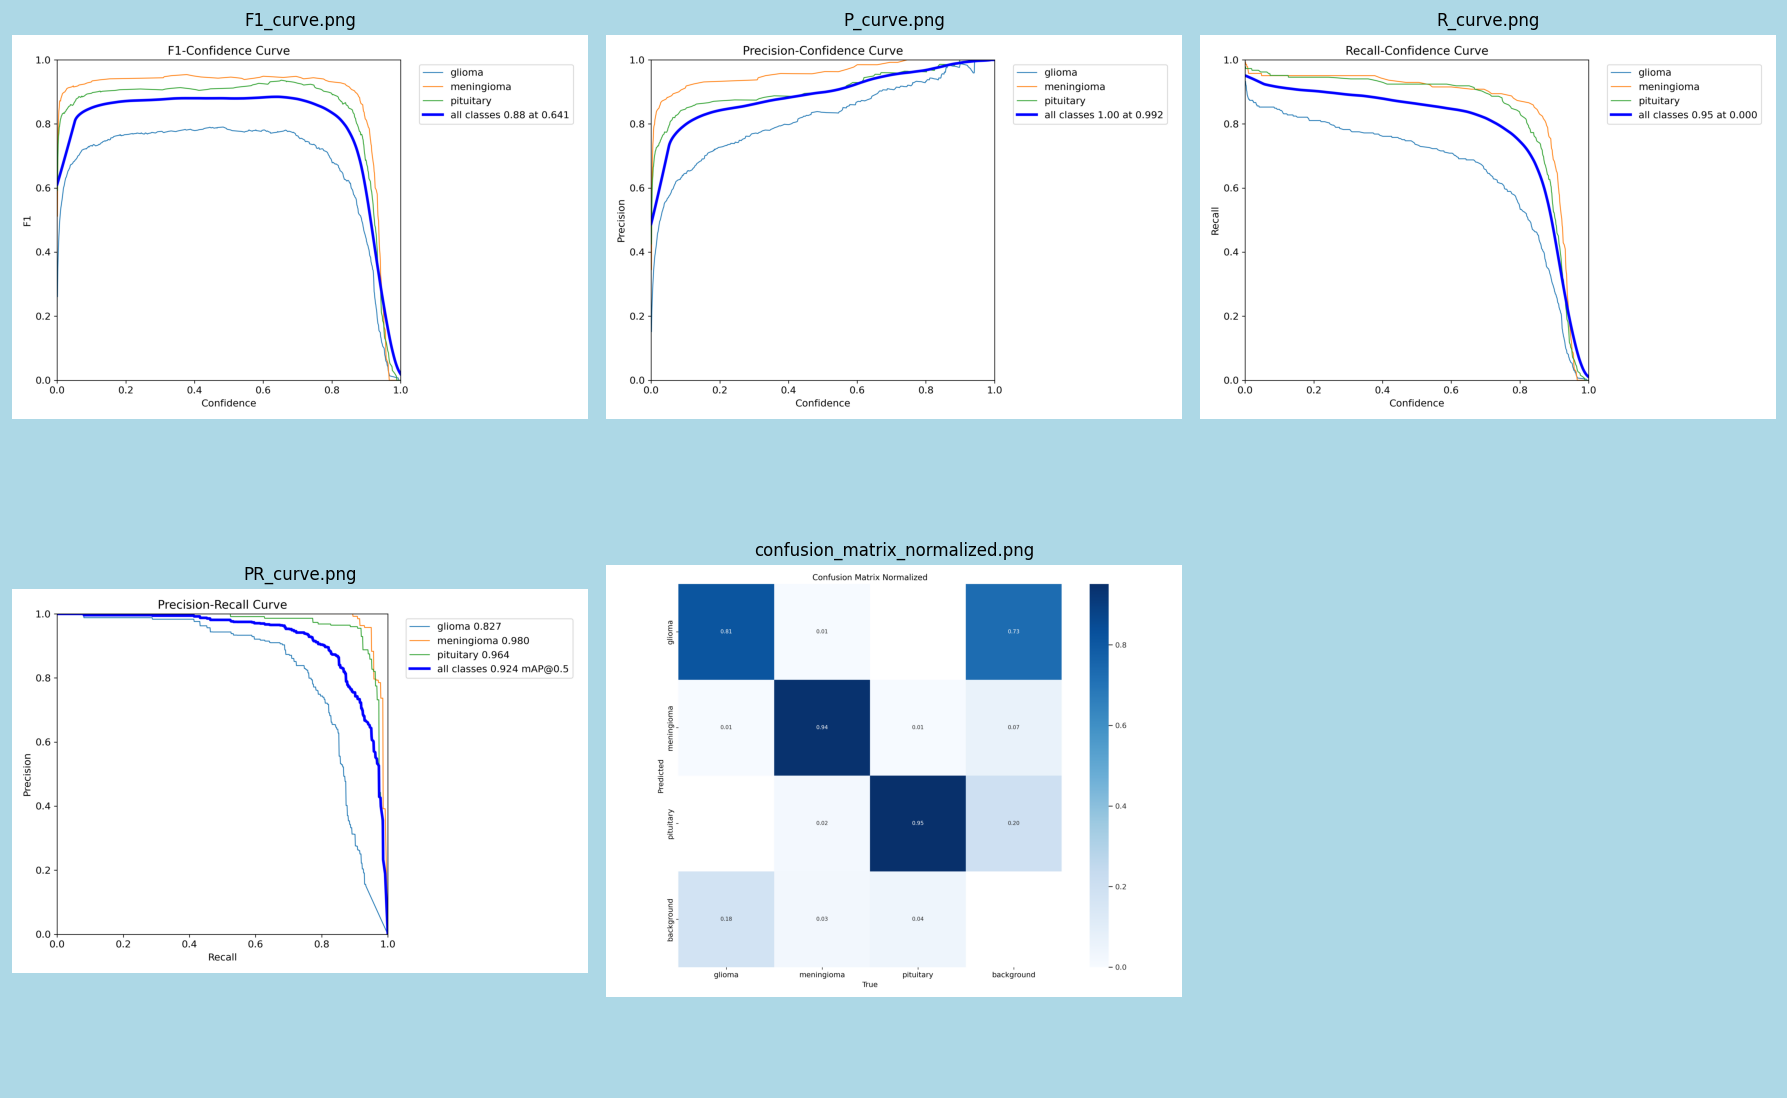

In [ ]:
def display_images_in_frame_with_background(post_training_files_path, image_files, background_color='lightgray'):
    num_images = len(image_files)
    cols = 3
    rows = (num_images + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), dpi=120)
    fig.patch.set_facecolor(background_color)
    axes = axes.flatten()
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(post_training_files_path, image_file)
        if os.path.exists(image_path):
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(image_file, fontsize=10, color='black')
        else:
            axes[i].axis('off')
            axes[i].set_title(f"{image_file} (Not Found)", fontsize=10, color='red')
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

image_files = [
    'F1_curve.png',
    'P_curve.png',
    'R_curve.png',
    'PR_curve.png',
    'confusion_matrix_normalized.png'
]
display_images_in_frame_with_background(post_training_files_path, image_files, background_color='lightblue')

In [ ]:
# Predict on test images
base_dir = Path("/content/drive/MyDrive/BrainTumorYolov8")  # Replace with your actual base path
image_dir = base_dir / "test/images"

# Get the first 3 files ending with .jpg or .jpeg (case-insensitive)
test_images = [
    f for f in image_dir.iterdir()
    if f.is_file() and f.name.lower().endswith(('.jpg', '.jpeg'))
][:15]

if test_images:
    results = best_model.predict(
        source=test_images,
        save=True,
        project='/content/drive/MyDrive/BrainTumorYolov8/yolov8_runs',
        name='predict'
    )
    print("Predictions saved in /content/drive/MyDrive/BrainTumorYolov8/yolov8_runs/predict1")
else:
    print("No test images found. Skipping prediction.")


0: 640x640 1 pituitary, 4.5ms
1: 640x640 1 meningioma, 4.5ms
2: 640x640 1 pituitary, 4.5ms
3: 640x640 1 pituitary, 4.5ms
4: 640x640 (no detections), 4.5ms
5: 640x640 1 meningioma, 4.5ms
6: 640x640 1 pituitary, 4.5ms
7: 640x640 1 pituitary, 4.5ms
8: 640x640 1 pituitary, 4.5ms
9: 640x640 1 meningioma, 4.5ms
10: 640x640 1 pituitary, 4.5ms
11: 640x640 1 pituitary, 4.5ms
12: 640x640 1 pituitary, 4.5ms
13: 640x640 1 pituitary, 4.5ms
14: 640x640 1 pituitary, 4.5ms
Speed: 2.3ms preprocess, 4.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/MyDrive/BrainTumorYolov8/yolov8_runs/predict2
Predictions saved in /content/drive/MyDrive/BrainTumorYolov8/yolov8_runs/predict1


# try till here


0: 640x640 1 pituitary, 11.7ms
Speed: 3.5ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 pituitary, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 pituitary, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 pituitary, 13.8ms
Speed: 2.3ms preprocess, 13.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 pituitary, 20.5ms
Speed: 14.7ms preprocess, 20.5ms inference, 8.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 glioma, 26.9ms
Speed: 2.9ms preprocess, 26.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 glioma, 45.5ms
Speed: 3.2ms preprocess, 45.5ms inference, 10.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.6ms
Speed: 3.1ms preprocess, 10.6ms inference, 1.0ms postprocess per imag

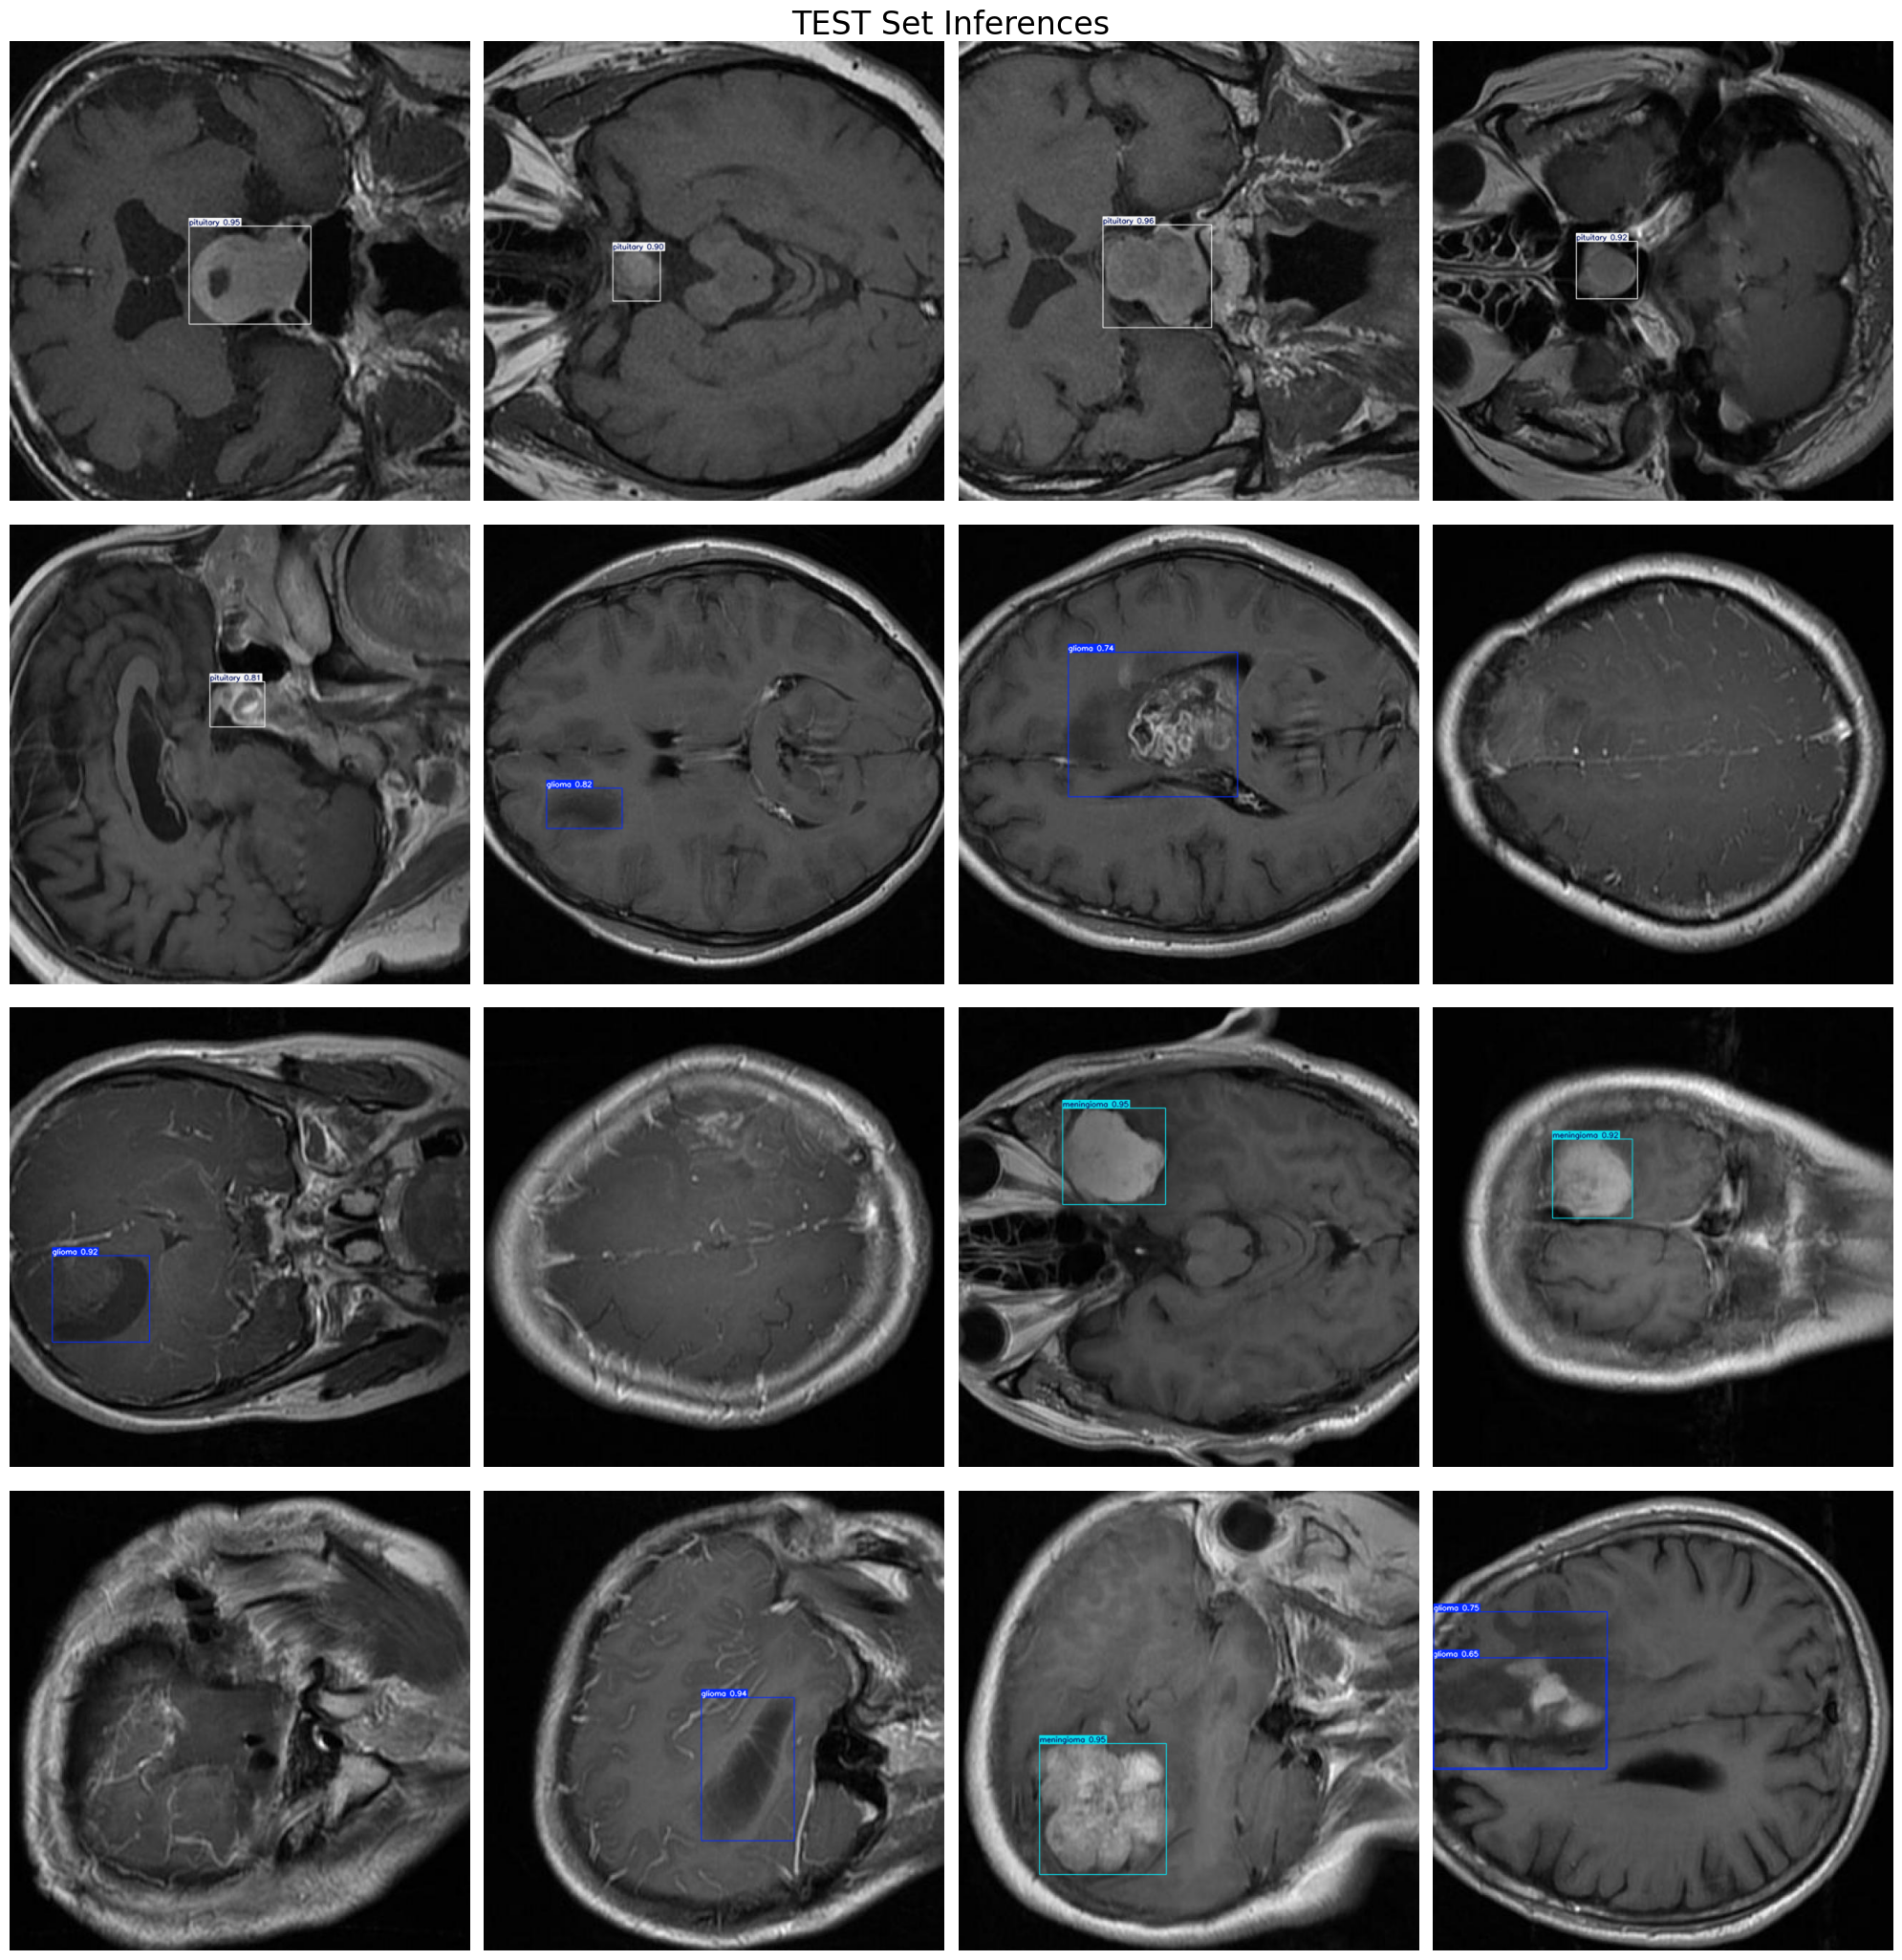

In [ ]:
3# Validation of Model by TestSet

# Normalization function
def normalize_image(image):
    return image / 255.0

# Image resizing function
def resize_image(image, size=(640, 640)):
    return cv2.resize(image, size)

# Path to validation images
dataset_path = '/content/drive/MyDrive/BrainTumorYolov8'  # Place your dataset path here
valid_images_path = os.path.join(dataset_path, 'test', 'images')

# List of all jpg images in the directory
image_files = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]

# Check if there are images in the directory
if len(image_files) > 0:
    # Select 9 images at equal intervals
    num_images = len(image_files)
    step_size = max(1, num_images // 16)  # Ensure the interval is at least 1
    selected_images = [image_files[i] for i in range(0, num_images, step_size)]

    # Prepare subplots
    fig, axes = plt.subplots(4, 4, figsize=(20, 21))
    fig.suptitle('TEST Set Inferences', fontsize=24)

    for i, ax in enumerate(axes.flatten()):
        if i < len(selected_images):
            image_path = os.path.join(valid_images_path, selected_images[i])

            # Load image
            image = cv2.imread(image_path)

            # Check if the image is loaded correctly
            if image is not None:
                # Resize image
                resized_image = resize_image(image, size=(640, 640))
                # Normalize image
                normalized_image = normalize_image(resized_image)

                # Convert the normalized image to uint8 data type
                normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)

                # Predict with the model
                results = best_model.predict(source=normalized_image_uint8, imgsz=640, conf=0.5)

                # Plot image with labels
                annotated_image = results[0].plot(line_width=1)
                annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
                ax.imshow(annotated_image_rgb)
            else:
                print(f"Failed to load image {image_path}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()